In [ ]:
import gym
import numpy as np
from typing import Tuple, List
import random
import matplotlib.pyplot as plt

In [31]:
class Battleship2(gym.Env):
    def __init__(self):
        """
        Initializes the Battleship2 environment.
        """
        self.observation_space = gym.spaces.Discrete(25)  # 5x5 grid
        self.action_space = gym.spaces.Discrete(25)       # 5x5 grid flattened to 25 actions
        self.battleshipCP = None
        self.hit = False
        self.hit_count = 0

    def step(self, action):
        """
        Executes one step in the environment.
        """
        assert self.action_space.contains(action), "Invalid action!"

        # Convert action index to grid coordinates
        x, y = divmod(action, 5)

        reward = -1
        done = False
        info = {}

        if self.battleshipCP[x, y] == 1:  # Hit
            reward = 2 if not self.hit else 5
            self.battleshipCP[x, y] = 0  # Mark hit
            self.hit = True
            self.hit_count += 1
            if self.hit_count == 2:  # Game won after second hit
                done = True
        else:  # Miss
            reward = -2 if self.hit else -1
            self.battleshipCP[x, y] = 2  # Mark miss

        next_state = action  # Update state (in this case, the action serves as state)
        return next_state, reward, done, info

    def reset(self):
        """
        Resets the environment for a new game.
        """
        self.battleshipCP = self.CPshipLoc()  # Initialize the ship's location
        self.hit = False
        self.hit_count = 0
        return 0  # Initial state

    def board(self):
        """
        Initializes an empty 5x5 board.
        """
        return np.zeros((5, 5), dtype=int)

    def Hozorvert(self):
        """
        Randomly determines ship orientation (0 = horizontal, 1 = vertical).
        """
        return np.random.randint(0, 2)

    def CPshipLoc(self):
        """
        Randomly generates the ship's location on the board.
        """
        board = self.board()
        orientation = self.Hozorvert()

        if orientation == 0:  # Horizontal placement
            row = np.random.randint(0, 5)
            start_col = np.random.randint(0, 4)
            board[row, start_col:start_col + 2] = 1
        else:  # Vertical placement
            col = np.random.randint(0, 5)
            start_row = np.random.randint(0, 4)
            board[start_row:start_row + 2, col] = 1

        return board


In [47]:
env = Battleship2()
env.reset()
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
c_qtable = np.zeros((state_space_size, action_space_size))
q_table = np.zeros((state_space_size, action_space_size))

num_episodes = 50000
max_steps_per_episode = 16

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

rewards_all_episodes = []
ep_count = []
graph_step = []
graph_ep = []
reward_pre = []
meanstep = []
tm = []

# Q-Learning algorithm
for episode in range(num_episodes):
    possible_action = list(range(25))  # Reset possible actions
    ship = env.reset()  # Reset the environment
    state = 0
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state, :])
        else:
            action = random.choice(possible_action)

        if action in possible_action:
            possible_action.remove(action)
        else:
            action = random.choice(possible_action)
            possible_action.remove(action)

        # Perform action
        next_state, reward, done, info = env.step(action)

        # Q-table update
        q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
            learning_rate * (reward + discount_rate * np.max(q_table[next_state, :]))
        state = next_state

        rewards_current_episode += reward

        if done:
            break

    graph_step.append(step)
    graph_ep.append(episode)
    reward_pre.append(rewards_current_episode)

    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

    rewards_all_episodes.append(rewards_current_episode)

# Calculate average reward per 100 episodes
rewards_per_hundred_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)
count = 0

print("********** Average reward per hundred episodes **********\n")

for i, r in enumerate(rewards_per_hundred_episodes):
    # Average reward for the current chunk
    avg_reward = np.mean(r)
    print(f"{count}: {avg_reward:.2f}")

    # Update metrics
    tm.append(avg_reward)
    meanstep.append(np.mean(graph_step[count:count + 100]))  # Average steps for the same range
    ep_count.append(count + 100)  # Track the episode count

    count += 100  # Increment the episode counter



********** Average reward per hundred episodes **********

0: -14.49
100: -14.30
200: -14.85
300: -14.46
400: -15.45
500: -15.46
600: -14.15
700: -14.79
800: -14.96
900: -14.34
1000: -14.27
1100: -14.73
1200: -13.54
1300: -13.31
1400: -15.52
1500: -15.08
1600: -13.69
1700: -13.93
1800: -13.77
1900: -14.58
2000: -13.47
2100: -14.22
2200: -15.10
2300: -15.54
2400: -13.20
2500: -13.92
2600: -15.21
2700: -14.33
2800: -15.32
2900: -15.11
3000: -15.15
3100: -15.11
3200: -14.17
3300: -14.44
3400: -14.80
3500: -13.66
3600: -15.54
3700: -14.18
3800: -15.08
3900: -15.48
4000: -15.59
4100: -13.75
4200: -14.14
4300: -15.07
4400: -14.15
4500: -15.19
4600: -15.03
4700: -14.35
4800: -14.79
4900: -14.69
5000: -14.08
5100: -14.17
5200: -13.38
5300: -14.17
5400: -13.77
5500: -13.94
5600: -13.12
5700: -14.25
5800: -13.68
5900: -15.40
6000: -14.36
6100: -14.98
6200: -14.30
6300: -15.16
6400: -14.47
6500: -14.18
6600: -14.71
6700: -15.86
6800: -17.05
6900: -16.16
7000: -14.12
7100: -12.71
7200: -15.04
7300


Negative Hypergeometric Distribution says:
    \begin{equation*}
        \mu = \frac{rK}{N-K+1}
    \end{equation*}

Using N = 25, K = miss = 23, and R = hits = 2. We expect our ship to get sank in around 15.5 turns.

Text(0.5, 1.0, 'Mean Step vs  Episodes')

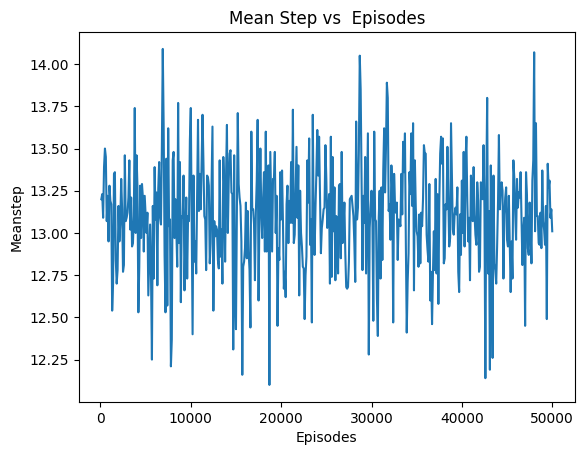

In [48]:
plt.plot(ep_count,meanstep)
plt.xlabel('Episodes')
plt.ylabel('Meanstep')
plt.title('Mean Step vs  Episodes')

able to see that our Qtable beats randomly guessing

Text(0.5, 1.0, 'Reward vs Episodes')

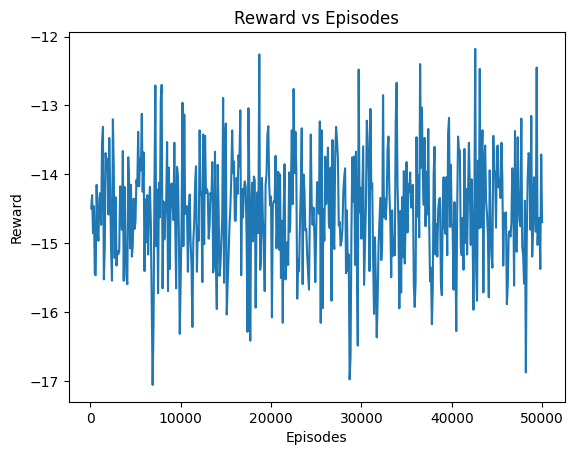

In [49]:
plt.plot(ep_count, tm)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episodes')